***DA3 Assignment 2 - Finding Fast Growing Firms***

**Muhammad Hamza Dhich 2304086**

**Zunaira Pasha 2203204**

### Importing Libraries

In [462]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report

import os
import sys
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import patsy
import sklearn.metrics as metrics
import statsmodels.formula.api as smf
from plotnine import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import (
    LinearRegression,
    LogisticRegression,
    LogisticRegressionCV,
)
from sklearn.metrics import (
    auc,
    brier_score_loss,
    confusion_matrix,
    mean_squared_error,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.tools.eval_measures import rmse

warnings.filterwarnings("ignore")


import os
import matplotlib.pyplot as plt
import seaborn as sns

## Data Preparation

In [523]:
import os
import urllib.request

osf_url = "https://osf.io/download/qwgyk"
destination_path = "py_helper_functions.py"  # Save it locally with this name

# Download the file from OSF and save it
urllib.request.urlretrieve(osf_url, destination_path)

# Now we can import it
import py_helper_functions


In [525]:
current_directory = os.getcwd()

In [527]:
data = pd.read_csv("https://osf.io/download/3qyut/")

In [529]:
# Count NAs in each column
to_filter = data.isna().sum()
# Sort and show only columns with missing values
to_filter = to_filter[to_filter > 0].sort_values()
to_filter

founded_date             51
share_eq                131
liq_assets              131
inventories             131
subscribed_cap          131
fixed_assets            131
curr_liab               131
curr_assets             131
intang_assets           140
region_m                840
nace_main              1038
ind2                   1038
tang_assets            1470
inc_bef_tax            7437
sales                  7437
personnel_exp          8040
amort                  8040
material_exp           8040
ind                    9769
profit_loss_year       9884
extra_profit_loss     17203
extra_inc             18529
extra_exp             18529
origin                56427
gender                56427
ceo_count             56427
foreign               56427
female                56427
inoffice_days         56427
founded_year          56457
birth_year           111818
labor_avg            146532
exit_date            231649
exit_year            248970
net_exp_sales        269572
net_dom_sales       

In [531]:
# Drop specific columns
columns_to_drop = ['COGS', 'finished_prod', 'net_dom_sales', 'net_exp_sales', 'wages', 'D']
data = data.drop(columns=columns_to_drop)

# Filter years between 2010-2015
data = data[(data['year'] >= 2010) & (data['year'] <= 2015)]


### Label Engineering

In [534]:

# generate status_alive to check if the firm is still alive
data['status_alive'] = ((data['sales'] > 0) & (~data['sales'].isna())).astype(int)

# Create log sales and sales in million
# Handle negative sales values
data['sales'].describe()

count    1.638640e+05
mean     4.662059e+05
std      3.789100e+06
min     -2.553889e+05
25%      3.092593e+03
50%      2.697037e+04
75%      1.060620e+05
max      1.110294e+08
Name: sales, dtype: float64

In [536]:
# Replace negative sales with 1, create log transformations
data['sales'] = np.where(data['sales'] < 0, 1, data['sales'])
data['ln_sales'] = np.where(data['sales'] > 0, np.log(data['sales']), 0)
data['sales_mil'] = data['sales']/1000000
data['sales_mil_log'] = np.where(data['sales'] > 0, np.log(data['sales_mil']), 0)
data['sales_mil_log_sq'] = data['sales_mil_log']**2

# Filter out non-alive firms and focus on specific revenue range
data = data[data['status_alive'] == 1]
data = data[~(data['sales_mil'] > 10)]  # not greater than 10m
data = data[~(data['sales_mil'] < 0.001)]  # not less than 1000 euros

# Keep only firms with data for all 6 years
# Group by company ID and count records
firm_counts = data.groupby('comp_id').size()
firms_with_6_years = firm_counts[firm_counts == 6].index
data = data[data['comp_id'].isin(firms_with_6_years)]

# Calculate change in sales (first difference)
# First sort data to ensure proper lag calculation
data = data.sort_values(['comp_id', 'year'])
# Create a shifted version for each company
data['sales_mil_log_lagged'] = data.groupby('comp_id')['sales_mil_log'].shift(1)
data['d1_sales_mil_log'] = data['sales_mil_log'] - data['sales_mil_log_lagged']
# Remove the temporary column if desired
data = data.drop(columns=['sales_mil_log_lagged'])

In [538]:
# Calculate age and create a 'new' firm indicator
data['age'] = np.where((data['year'] - data['founded_year']) < 0,
                       0,
                       data['year'] - data['founded_year'])

# Create 'new' flag for firms less than or equal to 1 year old
data['new'] = (data['age'] <= 1).astype(int)

# Adjust 'new' flag based on incomplete balance sheet information
data['new'] = np.where(data['balsheet_notfullyear'] == 1,
                      1,
                      data['new'])

# Set sales growth to 0 for new firms
data['d1_sales_mil_log'] = np.where(data['new'] == 1,
                                   0,
                                   data['d1_sales_mil_log'])

# Mark firms with missing growth data as new
data['new'] = np.where(data['d1_sales_mil_log'].isna(),
                      1,
                      data['new'])

# Replace missing growth values with 0
data['d1_sales_mil_log'] = np.where(data['d1_sales_mil_log'].isna(),
                                   0,
                                   data['d1_sales_mil_log'])

# Create flags for extreme growth values
data['flag_low_d1_sales_mil_log'] = np.where(data['d1_sales_mil_log'] < -1.5, 1, 0)
data['flag_high_d1_sales_mil_log'] = np.where(data['d1_sales_mil_log'] > 1.5, 1, 0)

# Create a modified growth variable with capped values (between -1.5 and 1.5)
data['d1_sales_mil_log_mod'] = np.where(data['d1_sales_mil_log'] < -1.5, -1.5,
                                      np.where(data['d1_sales_mil_log'] > 1.5, 1.5,
                                             data['d1_sales_mil_log']))

# Create squared term for the modified growth variable
data['d1_sales_mil_log_mod_sq'] = data['d1_sales_mil_log_mod']**2

# Show summary statistics for the growth variable
data['d1_sales_mil_log'].describe()

count    71154.000000
mean         0.021873
std          0.499078
min         -6.522003
25%         -0.093087
50%          0.000000
75%          0.161890
max          8.326700
Name: d1_sales_mil_log, dtype: float64

**Choosing CAGR over 2 years as fast growth indicator :**

The fast growth indicator we chose is based on a CAGR above 20% over two years, as it reflects sustained expansion rather than short-term spikes. To calculate this, we shift sales data forward by two years, compute CAGR, and filter out extreme values above 200%. Using CAGR instead of one-year growth provides a more reliable measure of long-term performance, avoiding distortions from temporary factors like seasonality or one-time events. Finally, firms exceeding 20% CAGR are classified as fast-growing (1), helping investors identify companies with consistent and scalable growth potential.


In [541]:
# Calculate Compound Annual Growth Rate (CAGR) for sales over 2 years
# First sort to ensure proper calculation
data = data.sort_values(['comp_id', 'year'])

# Calculate CAGR for each company
data['future_sales_mil'] = data.groupby('comp_id')['sales_mil'].shift(-2)  # sales 2 years later
data['cagr_sales'] = ((data['future_sales_mil'] / data['sales_mil'])**(1/2) - 1) * 100

# Filter the dataset
data = data[
    (data['year'] == 2012) &
    (~data['cagr_sales'].isna()) &
    (data['cagr_sales'] <= 200)
]

# Create fast growth dummy variable (firms with >20% CAGR)
data['fast_growth'] = (data['cagr_sales'] > 20).astype(int)



# Calculate age as year minus founding year (without replacing negatives)
data['age'] = data['year'] - data['founded_year']






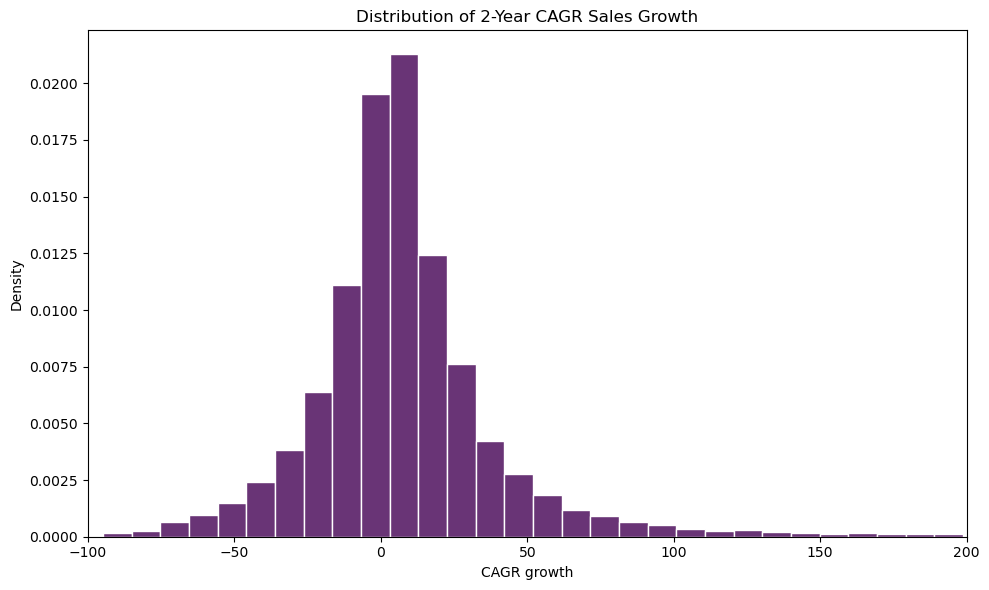

In [543]:
# Create a histogram of CAGR sales growth

plt.figure(figsize=(10, 6))
sns.histplot(data['cagr_sales'], bins=30, color='#440154', alpha=0.8,
             stat='density', edgecolor='white')
plt.xlim(-100, 200)
plt.xlabel('CAGR growth')
plt.ylabel('Density')
plt.title('Distribution of 2-Year CAGR Sales Growth')
plt.tight_layout()
plt.show()


In [545]:
# Display descriptive statistics
print(data['cagr_sales'].describe())


count    11747.000000
mean         7.697635
std         32.619771
min        -94.845325
25%         -8.061568
50%          4.759107
75%         19.048948
max        198.692205
Name: cagr_sales, dtype: float64


In [547]:
print(data['comp_id'].describe())

count    1.174700e+04
mean     1.543986e+11
std      1.381854e+11
min      1.002029e+06
25%      2.940722e+10
50%      1.158341e+11
75%      2.592432e+11
max      4.641050e+11
Name: comp_id, dtype: float64


In [549]:
print(data['fast_growth'].describe())

count    11747.000000
mean         0.239380
std          0.426723
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: fast_growth, dtype: float64


### Feature Engineering

In [552]:

# Change some industry category codes
data['ind2_cat'] = np.where(data['ind2'] > 56, 60, data['ind2'])
data['ind2_cat'] = np.where(data['ind2_cat'] < 26, 20, data['ind2_cat'])
data['ind2_cat'] = np.where((data['ind2_cat'] < 55) & (data['ind2_cat'] > 35), 40, data['ind2_cat'])
data['ind2_cat'] = np.where(data['ind2_cat'] == 31, 30, data['ind2_cat'])
data['ind2_cat'] = np.where(data['ind2_cat'].isna(), 99, data['ind2_cat'])

# Firm Characteristics
data['age2'] = data['age'] ** 2
data['foreign_management'] = (data['foreign'] >= 0.5).astype(int)
data['gender_m'] = pd.Categorical(data['gender'], categories=["female", "male", "mix"], ordered=False)
data['m_region_loc'] = pd.Categorical(data['region_m'], categories=["Central", "East", "West"], ordered=False)

# Financial Variables - Handling Negative Assets
data['flag_asset_problem'] = ((data[['intang_assets', 'curr_assets', 'fixed_assets']] < 0).any(axis=1)).astype(int)
data[['intang_assets', 'curr_assets', 'fixed_assets']] = data[['intang_assets', 'curr_assets', 'fixed_assets']].clip(lower=0)

# Generate total assets
data['total_assets_bs'] = data[['intang_assets', 'curr_assets', 'fixed_assets']].sum(axis=1)

# Creating financial ratios
pl_names = ["extra_exp", "extra_inc", "extra_profit_loss", "inc_bef_tax", "inventories", "material_exp", "profit_loss_year", "personnel_exp"]
bs_names = ["intang_assets", "curr_liab", "fixed_assets", "liq_assets", "curr_assets", "share_eq", "subscribed_cap", "tang_assets"]

data[[f"{col}_pl" for col in pl_names]] = data[pl_names].div(data['sales'], axis=0)
data[[f"{col}_bs" for col in bs_names]] = data[bs_names].div(data['total_assets_bs'].replace(0, np.nan), axis=0)

# Creating flags for variables that shouldn't exceed 1
zero_vars = [f"{col}_pl" for col in ["extra_exp", "extra_inc", "inventories", "material_exp", "personnel_exp"]] + [f"{col}_bs" for col in ["curr_liab", "fixed_assets", "liq_assets", "curr_assets", "subscribed_cap", "intang_assets"]]

data[[f"{col}_flag_high" for col in zero_vars]] = (data[zero_vars] > 1).astype(int)
data[zero_vars] = data[zero_vars].clip(upper=1)
data[[f"{col}_flag_error" for col in zero_vars]] = (data[zero_vars] < 0).astype(int)
data[zero_vars] = data[zero_vars].clip(lower=0)

# Variables that can be negative but should mostly be between -1 and 1
any_vars = ["extra_profit_loss_pl", "inc_bef_tax_pl", "profit_loss_year_pl", "share_eq_bs"]
data[[f"{col}_flag_low" for col in any_vars]] = (data[any_vars] < -1).astype(int)
data[any_vars] = data[any_vars].clip(lower=-1)
data[[f"{col}_flag_high" for col in any_vars]] = (data[any_vars] > 1).astype(int)
data[any_vars] = data[any_vars].clip(upper=1)
data[[f"{col}_flag_zero" for col in any_vars]] = (data[any_vars] == 0).astype(int)
data[[f"{col}_quad" for col in any_vars]] = data[any_vars] ** 2

# Dropping flags with no variation
flag_cols = [col for col in data.columns if "flag" in col]
data = data.drop(columns=[col for col in flag_cols if data[col].var() == 0])

# CEO Age Imputation
data['ceo_age'] = data['year'] - data['birth_year']
data['flag_low_ceo_age'] = ((data['ceo_age'] < 25) & data['ceo_age'].notna()).astype(int)
data['flag_high_ceo_age'] = ((data['ceo_age'] > 75) & data['ceo_age'].notna()).astype(int)
data['flag_miss_ceo_age'] = data['ceo_age'].isna().astype(int)

ceo_age_mean = data['ceo_age'].mean(skipna=True)
data['ceo_age'] = data['ceo_age'].clip(lower=25, upper=75).fillna(ceo_age_mean)
data['ceo_young'] = (data['ceo_age'] < 40).astype(int)

# Handling missing values in labor_avg
data['labor_avg_mod'] = data['labor_avg'].fillna(data['labor_avg'].mean())
data['flag_miss_labor_avg'] = data['labor_avg'].isna().astype(int)
data = data.drop(columns=['labor_avg'])

# Creating categorical variables
data['urban_m'] = pd.Categorical(data['urban_m'], categories=[1, 2, 3], ordered=False)
data['ind2_cat'] = pd.Categorical(data['ind2_cat'], categories=sorted(data['ind2_cat'].unique()), ordered=False)
data['fast_growth_f'] = data['fast_growth'].replace({0: 'no_fast_growth', 1: 'fast_growth'}).astype('category')

# Dropping missing values in key variables
data = data.dropna(subset=['liq_assets_bs', 'foreign', 'ind', 'age', 'material_exp_pl', 'm_region_loc'])

# Dropping unused factor levels
for col in data.select_dtypes(['category']).columns:
    data[col] = data[col].cat.remove_unused_categories()

### Visualizations ###

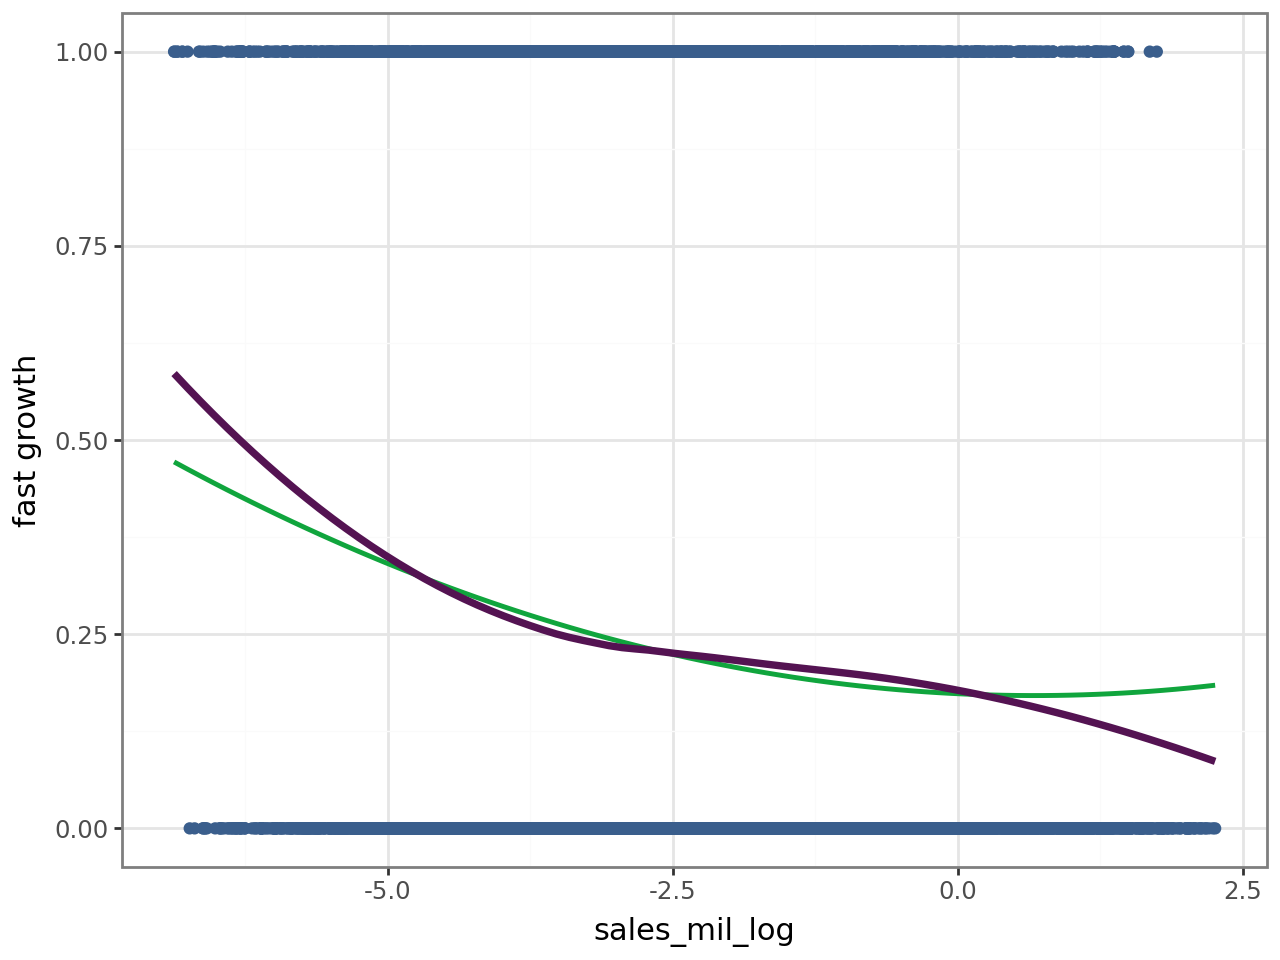

In [555]:
(
    ggplot(data, aes(x="sales_mil_log", y="fast_growth"))
    + geom_point(color=color[0])
    + geom_smooth(method="lm", formula="y ~ x + I(x**2)", color=color[1], se=False)
    + geom_smooth(method="loess", color=color[2], se=False, size=1.5, span=0.9)
    + labs(x="sales_mil_log", y="fast growth")
    + theme_bw()
)

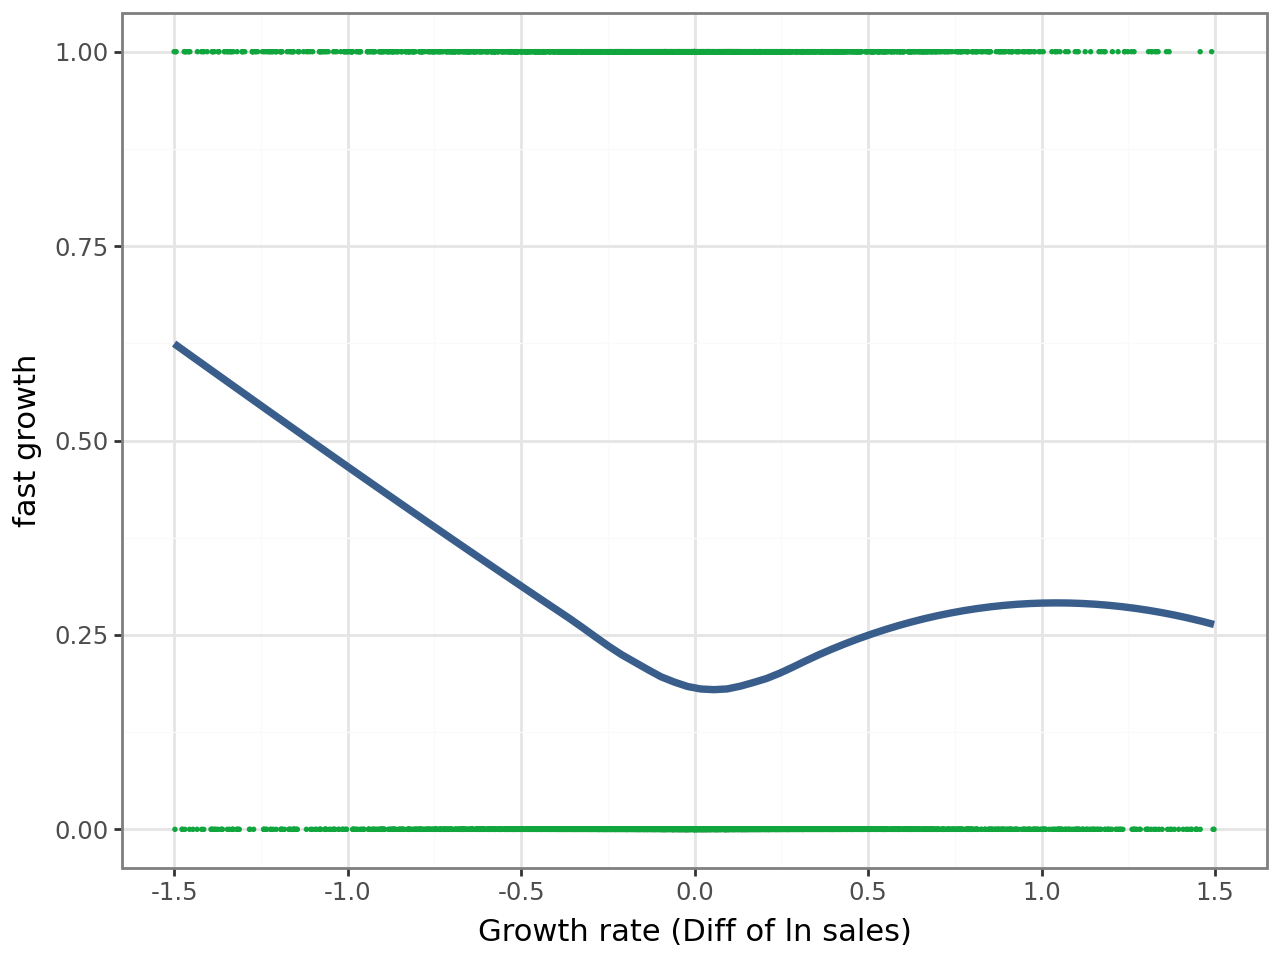

In [557]:
(
    ggplot(data, aes(x="d1_sales_mil_log", y="fast_growth"))
    + geom_point(size=0.1, color=color[1])
    + geom_smooth(method="loess", color=color[0], se=False, size=1.5, span=0.9)
    + labs(x="Growth rate (Diff of ln sales)", y="fast growth")
    + scale_x_continuous(limits=(-1.5, 1.5), breaks=seq(-1.5, 1.5, by=0.5))
    + theme_bw()
)

In [563]:
# Get the current directory
current_directory = os.getcwd()

# Define the output file path directly in the current directory
output_file_path = os.path.join(current_directory, "bisnode_cleaned.csv")

# Save the DataFrame to CSV
data.to_csv(output_file_path, index=False)

print(f"Cleaned data saved to: {output_file_path}")


Cleaned data saved to: C:\Users\T490\Downloads\bisnode_cleaned.csv


In [565]:
data.describe()


,comp_id,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,fixed_assets,inc_bef_tax,intang_assets,...,inc_bef_tax_pl_quad,profit_loss_year_pl_quad,share_eq_bs_quad,ceo_age,flag_low_ceo_age,flag_high_ceo_age,flag_miss_ceo_age,ceo_young,labor_avg_mod,flag_miss_labor_avg
count,1.049300e+04,1.049300e+04,1.049300e+04,1.049300e+04,10493.000000,1.049300e+04,1.049300e+04,1.049300e+04,1.049300e+04,1.049300e+04,...,10493.000000,10493.000000,10493.000000,10493.000000,10493.000000,10493.000000,10493.000000,10493.000000,10493.000000,10493.000000
mean,1.543570e+11,1.266824e+04,1.238455e+05,9.784211e+04,532.052708,2.112701e+03,1.574308e+03,1.969964e+05,1.439663e+04,3.870547e+03,...,0.085232,0.072230,0.444740,48.612207,0.004193,0.004098,0.122463,0.206614,0.747525,0.089298
std,1.380363e+11,5.779753e+04,4.082155e+05,3.277468e+05,8379.673407,4.161441e+04,4.054152e+04,1.314237e+06,1.094239e+05,5.191233e+04,...,0.209365,0.194049,0.366559,10.075832,0.064623,0.063887,0.327835,0.404895,1.595828,0.285186
min,1.002029e+06,-1.489630e+04,0.000000e+00,-8.759259e+03,-1418.518555,-1.740741e+02,-1.702444e+05,0.000000e+00,-1.984182e+06,0.000000e+00,...,0.000000,0.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.083333,0.000000
25%,2.941912e+10,3.851852e+02,6.192593e+03,4.959259e+03,0.000000,0.000000e+00,0.000000e+00,1.392593e+03,-3.470370e+03,0.000000e+00,...,0.000496,0.000229,0.091102,41.000000,0.000000,0.000000,0.000000,0.000000,0.152778,0.000000
50%,1.167555e+11,1.892593e+03,1.954445e+04,1.890370e+04,0.000000,0.000000e+00,0.000000e+00,1.381111e+04,1.000000e+03,0.000000e+00,...,0.005477,0.003073,0.370600,48.651276,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000
75%,2.574332e+11,7.277778e+03,6.711111e+04,6.431111e+04,0.000000,0.000000e+00,0.000000e+00,8.321111e+04,8.177778e+03,0.000000e+00,...,0.048334,0.034604,0.798868,56.000000,0.000000,0.000000,0.000000,0.000000,0.741729,0.000000
max,4.641050e+11,3.570863e+06,9.055026e+06,1.297067e+07,666300.000000,3.266667e+06,3.253704e+06,1.036673e+08,4.378226e+06,3.154444e+06,...,1.000000,1.000000,1.000000,75.000000,1.000000,1.000000,1.000000,1.000000,37.500000,1.000000


# Task 1

## Part 1: Probability Prediction

#### Define Helper Functions

In [218]:
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance = metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error = metrics.mean_absolute_error(y_true, y_pred)
    mse = metrics.mean_squared_error(y_true, y_pred)
    median_absolute_error = metrics.median_absolute_error(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)

    print("explained_variance: ", round(explained_variance, 4))
    print("r2: ", round(r2, 4))
    print("MAE: ", round(mean_absolute_error, 4))
    print("MSE: ", round(mse, 4))
    print("RMSE: ", round(np.sqrt(mse), 4))


def coef_matrix(X, model):

    coef_matrix = pd.concat(
        [pd.DataFrame(X.columns), pd.DataFrame(np.transpose(model.coef_))], axis=1
    )
    coef_matrix.columns = ["variable", "coefficient"]
    coef_matrix = coef_matrix.append(
        {"variable": "Intercept", "coefficient": model.intercept_},
        ignore_index=True,
    )
    return coef_matrix


def cv_summary(lambdas, C_values, model):
    d = {
        "lambdas": lambdas,
        "C_values": C_values,
        "mean_cv_score": model.scores_[1].mean(axis=0),
    }
    return pd.DataFrame(data=d)


def create_roc_plot(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    all_coords = pd.DataFrame({"fpr": fpr, "tpr": tpr, "thresholds": thresholds})

    plot = (
        ggplot(all_coords, aes(x="fpr", y="tpr"))
        + geom_line(color=color[0], size=0.7)
        + geom_area(position="identity", fill="mediumaquamarine", alpha=0.3)
        + xlab("False Positive Rate (1-Specifity)")
        + ylab("True Positive Rate (Sensitivity)")
        + geom_abline(intercept=0, slope=1, linetype="dotted", color="black")
        + scale_y_continuous(limits=(0, 1), breaks=seq(0, 1, 0.1), expand=(0, 0.01))
        + scale_x_continuous(limits=(0, 1), breaks=seq(0, 1, 0.1), expand=(0.01, 0))
        + theme_bw()
    )
    return plot


def sigmoid_array(x):
    return 1 / (1 + np.exp(-x))


def generate_fold_prediction(model, X, fold, param_index):
    fold_coef = model.coefs_paths_[1][fold, param_index, :]
    return sigmoid_array(
        np.dot(X, np.transpose(fold_coef)[:-1]) + np.transpose(fold_coef)[-1]
    )


def create_loss_plot(all_coords, optimal_threshold, curr_exp_loss):
    all_coords_copy = all_coords.copy()
    all_coords_copy["loss"] = (
        all_coords_copy.false_pos * FP + all_coords_copy.false_neg * FN
    ) / all_coords_copy.n

    t = optimal_threshold
    l = curr_exp_loss

    plot = (
        ggplot(all_coords_copy, aes(x="thresholds", y="loss"))
        + geom_line(color=color[0], size=0.7)
        + scale_x_continuous(breaks=seq(0, 1.1, by=0.1))
        + coord_cartesian(xlim=(0, 1))
        + geom_vline(xintercept=t, color=color[0])
        + annotate(
            geom="text",
            x=t - 0.01,
            y=max(all_coords_copy.loss) - 0.4,
            label="best threshold: " + str(round(t, 2)),
            colour=color[1],
            angle=90,
            size=7,
        )
        + annotate(geom="text", x=t + 0.06, y=l, label=str(round(l, 2)), size=7)
        + theme_bw()
    )
    return plot


def create_roc_plot_with_optimal(all_coords, optimal_threshold):
    all_coords_copy = all_coords.copy()
    all_coords_copy["sp"] = 1 - all_coords_copy.true_neg / all_coords_copy.neg
    all_coords_copy["se"] = all_coords_copy.true_pos / all_coords_copy.pos

    best_coords = all_coords_copy[all_coords_copy.thresholds == optimal_threshold]
    sp = best_coords.sp.values[0]
    se = best_coords.se.values[0]

    plot = (
        ggplot(all_coords_copy, aes(x="sp", y="se"))
        + geom_line(color=color[0], size=0.7)
        + scale_y_continuous(breaks=seq(0, 1.1, by=0.1))
        + scale_x_continuous(breaks=seq(0, 1.1, by=0.1))
        + geom_point(data=pd.DataFrame({"sp": [sp], "se": [se]}))
        + annotate(
            geom="text",
            x=sp,
            y=se + 0.03,
            label=str(round(sp, 2)) + ", " + str(round(se, 2)),
            size=7,
        )
        + geom_area(position="identity", fill="mediumaquamarine", alpha=0.3)
        + xlab("False Positive Rate (1-Specifity)")
        + ylab("True Positive Rate (Sensitivity)")
        + geom_abline(intercept=0, slope=1, linetype="dotted", color="black")
        + theme_bw()
    )
    return plot

In [193]:
# Define variable sets
rawvars = [
    "curr_assets", "curr_liab", "extra_exp", "extra_inc", "extra_profit_loss", "fixed_assets",
    "inc_bef_tax", "intang_assets", "inventories", "liq_assets", "material_exp", "personnel_exp",
    "profit_loss_year", "sales", "share_eq", "subscribed_cap"
]

qualityvars = [
    "balsheet_flag", "balsheet_length", "balsheet_notfullyear"
]

engvar = [
    "total_assets_bs", "fixed_assets_bs", "liq_assets_bs", "curr_assets_bs",
    "share_eq_bs", "subscribed_cap_bs", "intang_assets_bs", "extra_exp_pl",
    "extra_inc_pl", "extra_profit_loss_pl", "inc_bef_tax_pl", "inventories_pl",
    "material_exp_pl", "profit_loss_year_pl", "personnel_exp_pl"
]

engvar2 = [
    "extra_profit_loss_pl_quad", "inc_bef_tax_pl_quad",
    "profit_loss_year_pl_quad", "share_eq_bs_quad"
]

engvar3 = (
    [col for col in data.columns if col.endswith("flag_low")] +
    [col for col in data.columns if col.endswith("flag_high")] +
    [col for col in data.columns if col.endswith("flag_error")] +
    [col for col in data.columns if col.endswith("flag_zero")]
)

d1 = [
    "d1_sales_mil_log_mod", "d1_sales_mil_log_mod_sq",
    "flag_low_d1_sales_mil_log", "flag_high_d1_sales_mil_log"
]

hr = [
    "female", "ceo_age", "flag_high_ceo_age", "flag_low_ceo_age",
    "flag_miss_ceo_age", "ceo_count", "labor_avg_mod",
    "flag_miss_labor_avg", "foreign_management"
]

firm = [
    "age", "age2", "new", "ind2_cat", "m_region_loc", "urban_m"
]

# Interactions for logit, LASSO
interactions1 = [
    "ind2_cat*age", "ind2_cat*age2",
    "ind2_cat*d1_sales_mil_log_mod", "ind2_cat*sales_mil_log",
    "ind2_cat*ceo_age", "ind2_cat*foreign_management",
    "ind2_cat*female", "ind2_cat*urban_m", "ind2_cat*labor_avg_mod"
]

interactions2 = [
    "sales_mil_log*age", "sales_mil_log*female",
    "sales_mil_log*profit_loss_year_pl", "sales_mil_log*foreign_management"
]

# Define variable sets for models
M1 = [
    "sales_mil_log", "sales_mil_log_sq", "d1_sales_mil_log_mod", "profit_loss_year_pl", "ind2_cat"
]

M2 = [
    "sales_mil_log", "sales_mil_log_sq", "d1_sales_mil_log_mod", "profit_loss_year_pl",
    "fixed_assets_bs", "share_eq_bs", "curr_liab_bs", "curr_liab_bs_flag_high",
    "curr_liab_bs_flag_error", "age", "foreign_management", "ind2_cat"
]

M3 = [
    "sales_mil_log", "sales_mil_log_sq", *firm, *engvar, *d1
]

M4 = [
    "sales_mil_log", "sales_mil_log_sq", *firm, *engvar, *engvar2, *engvar3, *d1, *hr, *qualityvars
]

M5 = [
    "sales_mil_log", "sales_mil_log_sq", *firm, *engvar, *engvar2, *engvar3, *d1, *hr, *qualityvars,
    *interactions1, *interactions2
]

# For LASSO
logit_lasso_vars = [
    "sales_mil_log", "sales_mil_log_sq", *engvar, *engvar2, *engvar3, *d1, *hr, *firm, *qualityvars,
    *interactions1, *interactions2
]

# For Random Forest
rfvars = [
    "sales_mil", "d1_sales_mil_log", *rawvars, *hr, *firm, *qualityvars
]

### Probability models quick test:

Linear Probability model

In [137]:
ols_modelx2 = smf.ols("fast_growth~" + "+".join(M2), data).fit(cov_type="HC1")
ols_modelx2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            fast_growth   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     25.59
Date:                Fri, 07 Mar 2025   Prob (F-statistic):           1.93e-84
Time:                        17:35:26   Log-Likelihood:                -5700.0
No. Observations:               10493   AIC:                         1.144e+04
Df Residuals:                   10474   BIC:                         1.158e+04
Df Model:                          18                                         
Covariance Type:                  HC1                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.2776      0.023     11.849      0.000       0.232       0.324
ind2_cat[T.27.0]            0.0286      0.027      1.070      0.284      -0.024       0.081
ind2_cat[T.28.0]            0.0022      0.020      0.111      0.912      -0.037       0.041
ind2_cat[T.29.0]            0.0483      0.038      1.287      0.198      -0.025       0.122
ind2_cat[T.30.0]            0.0539      0.049      1.102      0.271      -0.042       0.150
ind2_cat[T.33.0]            0.0041      0.021      0.193      0.847      -0.037       0.045
ind2_cat[T.55.0]           -0.0744      0.021     -3.609      0.000      -0.115      -0.034
ind2_cat[T.56.0]           -0.0814      0.018     -4.588      0.000      -0.116      -0.047
sales_mil_log              -0.0088      0.006     -1.520      0.128      -0.020       0.003
sales_mil_log_sq            0.0043      0.001      3.562      0.000       0.002       0.007
d1_sales_mil_log_mod       -0.0324      0.011     -2.950      0.003      -0.054      -0.011
profit_loss_year_pl        -0.1378      0.019     -7.269      0.000      -0.175      -0.101
fixed_assets_bs             0.0098      0.014      0.717      0.473      -0.017       0.037
share_eq_bs                 0.0125      0.011      1.155      0.248      -0.009       0.034
curr_liab_bs                0.0454      0.019      2.405      0.016       0.008       0.082
curr_liab_bs_flag_high     -0.0039      0.018     -0.222      0.824      -0.039       0.031
curr_liab_bs_flag_error     0.1254      0.171      0.734      0.463      -0.210       0.460
age                        -0.0076      0.001    -11.005      0.000      -0.009      -0.006
foreign_management          0.0064      0.014      0.457      0.648      -0.021       0.034
==============================================================================
Omnibus:                     1670.914   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2445.851
Skew:                           1.165   Prob(JB):                         0.00
Kurtosis:                       2.592   Cond. No.                         747.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

In [139]:
logit_modelx2 = smf.logit("fast_growth~" + "+".join(M2), data).fit()

Optimization terminated successfully.
         Current function value: 0.527528
         Iterations 6


In [141]:
logit_modelx2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            fast_growth   No. Observations:                10493
Model:                          Logit   Df Residuals:                    10474
Method:                           MLE   Df Model:                           18
Date:                Fri, 07 Mar 2025   Pseudo R-squ.:                 0.03863
Time:                        17:35:27   Log-Likelihood:                -5535.4
converged:                       True   LL-Null:                       -5757.8
Covariance Type:            nonrobust   LLR p-value:                 3.859e-83
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -0.9878      0.133     -7.444      0.000      -1.248      -0.728
ind2_cat[T.27.0]            0.1584      0.141      1.119      0.263      -0.119       0.436
ind2_cat[T.28.0]            0.0165      0.109      0.151      0.880      -0.197       0.230
ind2_cat[T.29.0]            0.2663      0.195      1.366      0.172      -0.116       0.648
ind2_cat[T.30.0]            0.2623      0.234      1.120      0.263      -0.197       0.722
ind2_cat[T.33.0]            0.0080      0.111      0.072      0.943      -0.209       0.225
ind2_cat[T.55.0]           -0.4372      0.118     -3.709      0.000      -0.668      -0.206
ind2_cat[T.56.0]           -0.4694      0.098     -4.796      0.000      -0.661      -0.278
sales_mil_log              -0.0795      0.039     -2.028      0.043      -0.156      -0.003
sales_mil_log_sq            0.0174      0.007      2.456      0.014       0.004       0.031
d1_sales_mil_log_mod       -0.1678      0.054     -3.081      0.002      -0.275      -0.061
profit_loss_year_pl        -0.6968      0.095     -7.314      0.000      -0.884      -0.510
fixed_assets_bs             0.0417      0.079      0.530      0.596      -0.112       0.196
share_eq_bs                 0.0646      0.062      1.041      0.298      -0.057       0.186
curr_liab_bs                0.2649      0.107      2.484      0.013       0.056       0.474
curr_liab_bs_flag_high     -0.0261      0.097     -0.268      0.789      -0.217       0.165
curr_liab_bs_flag_error     0.6098      0.961      0.635      0.526      -1.274       2.493
age                        -0.0439      0.004    -10.931      0.000      -0.052      -0.036
foreign_management          0.0486      0.082      0.589      0.556      -0.113       0.210
===========================================================================================
"""

In [143]:
logit_modelx2.get_margeff().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:            fast_growth
Method:                          dydx
At:                           overall
===========================================================================================
                             dy/dx    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
ind2_cat[T.27.0]            0.0275      0.025      1.120      0.263      -0.021       0.076
ind2_cat[T.28.0]            0.0029      0.019      0.151      0.880      -0.034       0.040
ind2_cat[T.29.0]            0.0462      0.034      1.367      0.172      -0.020       0.112
ind2_cat[T.30.0]            0.0455      0.041      1.120      0.263      -0.034       0.125
ind2_cat[T.33.0]            0.0014      0.019      0.072      0.943      -0.036       0.039
ind2_cat[T.55.0]           -0.0758      0.020     -3.715      0.000      -0.116      -0.036
ind2_cat[T.56.0]           -0.0814      0.017     -4.810      0.000      -0.115      -0.048
sales_mil_log              -0.0138      0.007     -2.028      0.043      -0.027      -0.000
sales_mil_log_sq            0.0030      0.001      2.459      0.014       0.001       0.005
d1_sales_mil_log_mod       -0.0291      0.009     -3.085      0.002      -0.048      -0.011
profit_loss_year_pl        -0.1208      0.016     -7.374      0.000      -0.153      -0.089
fixed_assets_bs             0.0072      0.014      0.530      0.596      -0.019       0.034
share_eq_bs                 0.0112      0.011      1.041      0.298      -0.010       0.032
curr_liab_bs                0.0459      0.018      2.486      0.013       0.010       0.082
curr_liab_bs_flag_high     -0.0045      0.017     -0.268      0.789      -0.038       0.029
curr_liab_bs_flag_error     0.1057      0.167      0.635      0.526      -0.221       0.432
age                        -0.0076      0.001    -11.098      0.000      -0.009      -0.006
foreign_management          0.0084      0.014      0.589      0.556      -0.020       0.036
===========================================================================================
"""

#### 0. Separate train and holdout data

In [146]:
data_train, data_holdout = train_test_split(data, train_size=0.8, random_state=42)

In [148]:
print("Total")
print(data["fast_growth"].value_counts(normalize=True))
print("Train")
print(data_train["fast_growth"].value_counts(normalize=True))
print("Holdout")
print(data_holdout["fast_growth"].value_counts(normalize=True))

Total
fast_growth
0    0.762032
1    0.237968
Name: proportion, dtype: float64
Train
fast_growth
0    0.764236
1    0.235764
Name: proportion, dtype: float64
Holdout
fast_growth
0    0.753216
1    0.246784
Name: proportion, dtype: float64


### 1) Logit Model with CV

In [174]:
# Specify 5 fold cross-validation method
k = KFold(n_splits=5, shuffle=True, random_state=42)

In [176]:
#Set up X-vars

logit_model_vars = [M1, M2, M3, M4, M5]

Set up Logit model object

No regularisation needed so setting the paremeter to very high value

In [179]:
C_value_logit = [1e20]

In [181]:
logit_models = dict()
CV_RMSE_folds = dict()

for i, model_vars in enumerate(logit_model_vars):

    model_equation = "fast_growth~" + "+".join(model_vars)
    y_train, X_train = patsy.dmatrices(model_equation, data_train)

    LRCV_brier = LogisticRegressionCV(
        Cs=C_value_logit,
        cv=k,
        refit=True,
        scoring="neg_brier_score",
        solver="newton-cg",
        tol=1e-7,
        random_state=42,
    )

    logit_models["M" + str(i + 1)] = LRCV_brier.fit(X_train, y_train)

    # Calculate RMSE on test for each fold
    CV_RMSE_folds["M" + str(i + 1)] = np.sqrt(
        -1 * logit_models["M" + str(i + 1)].scores_[1].ravel()
    )

In [183]:
pd.DataFrame(CV_RMSE_folds)

,M1,M2,M3,M4,M5
0,0.420748,0.418996,0.417536,0.416264,0.418222
1,0.415982,0.413959,0.411548,0.411949,0.414574
2,0.415077,0.411688,0.409785,0.408819,0.408957
3,0.419987,0.418569,0.415383,0.415146,0.418261
4,0.420404,0.418054,0.413167,0.411109,0.410574


Choose **M4** for its superior performance, as it consistently achieves the lowest RMSE across folds, offering the best predictive accuracy. While slightly more complex than **M3**, its performance gains justify the added complexity, making it a more reliable choice than **M5**.

### 2. Logit LASSO Model

In [195]:
model_equation = "fast_growth~" + "+".join(logit_lasso_vars)
y_train, X_train = patsy.dmatrices(model_equation, data_train)

In [197]:
#Normalise X vars for Lasso

normalized_logitvars = pd.DataFrame(
    StandardScaler().fit_transform(X_train),
    columns=X_train.design_info.column_names,
)

In [199]:
#Set regularization parameters

lambdas = list(10 ** np.arange(-1, -4.01, -1 / 3))
n_obs = normalized_logitvars.shape[0] * 4 / 5
C_values = [
    1 / (l * n_obs) for l in lambdas
]  # Cs are the inverse of regularization strength

Initialize and fit Logit Lasso

In [204]:
logLasso_brier = LogisticRegressionCV(
    Cs=C_values,
    penalty="l1",
    cv=k,
    refit=True,
    scoring="neg_brier_score",
    solver="liblinear",
    random_state=42,
)

logit_models["LASSO"] = logLasso_brier.fit(normalized_logitvars, y_train)

See CV-fold RMSE-s (negative brier score)

In [221]:
cv_summary_lasso = cv_summary(lambdas, C_values, logit_models["LASSO"])
cv_summary_lasso["mean_cv_score"] = np.sqrt(cv_summary_lasso["mean_cv_score"] * -1)
cv_summary_lasso

,lambdas,C_values,mean_cv_score
0,0.100000,0.001489,0.436097
1,0.046416,0.003208,0.425331
2,0.021544,0.006912,0.417370
3,0.010000,0.014892,0.413869
4,0.004642,0.032083,0.412313
5,0.002154,0.069121,0.412531
6,0.001000,0.148916,0.412910
7,0.000464,0.320830,0.413630
8,0.000215,0.691206,0.414223
9,0.000100,1.489159,0.414622


As λ decreases (or C increases), the mean_cv_score initially improves but worsens after a point, indicating that both excessive regularization (small C) and insufficient regularization (large C) harm model performance. The best λ is 0.004642 (or C = 0.032083), corresponding to the lowest mean_cv_score of 0.412313. Save best lambda's index for later use

In [231]:
best_lambda_i = cv_summary_lasso["mean_cv_score"].idxmin()

Extract CV test RMSE for the Lasso with best lambda

In [234]:
CV_RMSE_folds["LASSO"] = np.sqrt(
    -1 * logit_models["LASSO"].scores_[1][:, best_lambda_i]
)

### 3. Random Forest Model

In [237]:
y_train, rfvars_train = patsy.dmatrices("fast_growth~" + "+".join(rfvars), data_train)
y_holdout, rfvars_holdout = patsy.dmatrices("fast_growth~" + "+".join(rfvars), data_holdout)

Split by gini, ratio of 1's in each tree, average over trees

Chose this grid to optimize performance and prevent overfitting for a medium-sized dataset (10k rows, 10+ features), balancing feature selection (max_features), split quality (min_samples_split), and ensemble size of 100 (default n_estimators).

In [239]:
grid = {
    "max_features": [5, 6, 7],
    "criterion": ["gini"],
    "min_samples_split": [11, 16],
} 

5 fold cross validation

In [243]:
prob_forest = RandomForestClassifier(random_state=42, n_estimators=500, oob_score=True)
prob_forest_grid = GridSearchCV(
    prob_forest,
    grid,
    cv=k,
    refit="roc_auc",
    scoring=["roc_auc", "neg_brier_score"],
)

In [245]:
prob_forest_fit = prob_forest_grid.fit(rfvars_train, y_train)

Create CV summary table

In [248]:
prob_forest_cv_results = pd.DataFrame(
    {
        "max_features": prob_forest_fit.cv_results_["param_max_features"],
        "min_samples_split": prob_forest_fit.cv_results_["param_min_samples_split"],
        "cv_auc": prob_forest_fit.cv_results_["mean_test_roc_auc"],
        "cv_rmse": np.sqrt(
            prob_forest_fit.cv_results_["mean_test_neg_brier_score"] * -1
        ),
    }
)

prob_forest_cv_results

,max_features,min_samples_split,cv_auc,cv_rmse
0,5,11,0.653352,0.412235
1,5,16,0.653364,0.412120
2,6,11,0.653177,0.412390
3,6,16,0.654405,0.412199
4,7,11,0.653464,0.412362
5,7,16,0.653832,0.412138


In [263]:
best_mtry = prob_forest_fit.best_params_["max_features"]
best_min_node_size = prob_forest_fit.best_params_["min_samples_split"]
prob_forest_fit.best_params_

{'criterion': 'gini', 'max_features': 6, 'min_samples_split': 16}

The best configuration is max_features=6 and min_samples_split=16, as it achieves the highest CV AUC (0.654405) and lowest CV RMSE (0.412120), indicating optimal balance between model performance and generalization.Tt boosts performance (highest AUC, lowest RMSE) while avoiding overfitting. By using 6 features, it keeps the model focused yet flexible, and min_samples_split=16 ensures splits are meaningful.

Other combinations perform similarly, suggesting robustness across hyperparameters.

In [277]:
prob_forest_best_results = prob_forest_cv_results[
    (prob_forest_cv_results.max_features == best_mtry)
    & (prob_forest_cv_results.min_samples_split == best_min_node_size)
]
prob_forest_best_results_index = prob_forest_best_results.index.values[0]

### Comparing Model Performances in terms of Prediction Probabilities

Calculating AUC for Logit Model

In [282]:
CV_AUC_folds = dict()
for i, model_vars in enumerate(logit_model_vars):

    model_equation = "fast_growth~" + "+".join(model_vars)
    y_train, X_train = patsy.dmatrices(model_equation, data_train)

    LRCV_auc = LogisticRegressionCV(
        Cs=C_value_logit,
        cv=k,
        refit=True,
        scoring="roc_auc",
        solver="newton-cg",
        tol=1e-7,
        random_state=42,
    )

    logit_models["M" + str(i + 1)] = LRCV_auc.fit(X_train, y_train)

    # Calculate AUC on test for each fold
    CV_AUC_folds["M" + str(i + 1)] = logit_models["M" + str(i + 1)].scores_[1].ravel()

Calculating AUC for LASSO Model

In [288]:
logLasso_auc = LogisticRegressionCV(
    Cs=C_values,
    penalty="l1",
    cv=k,
    refit=True,
    scoring="roc_auc",
    solver="liblinear",
    random_state=42,
)
logLasso_auc_fitted = logLasso_auc.fit(normalized_logitvars, y_train)

CV_AUC_folds["LASSO"] = logLasso_auc_fitted.scores_[1][
    :, cv_summary_lasso["mean_cv_score"].idxmin()
]

Creating a summary for all 3 models

In [295]:
model_fits = pd.DataFrame(logit_models, index=["Model fit"]).T

summary = (
    model_fits["Model fit"]
    .apply(lambda x: x.n_features_in_)
    .to_frame(name="Number of Coefficients")
)

summary.loc["LASSO", "Number of Coefficients"] = len(
    [i for i in model_fits.loc["LASSO"].values[0].coef_[0] if i != 0]
)

summary["CV RMSE"] = pd.DataFrame(CV_RMSE_folds).T.mean(axis=1)
summary["CV AUC"] = pd.DataFrame(CV_AUC_folds).T.mean(axis=1)

In [297]:
sum(x != 0 for x in model_fits.loc["LASSO"].values[0].coef_[0].tolist())

57

In [299]:
len(
    [i for i in model_fits.loc["LASSO"].values[0].coef_[0] if i != 0]
)

57

Adding RF results to the summary as well

In [307]:
summary.loc["RF", "Number of Coefficients"] = "n.a."
summary.loc["RF", "CV RMSE"] = prob_forest_best_results["cv_rmse"].values[0]
summary.loc["RF", "CV AUC"] = prob_forest_best_results["cv_auc"].values[0]


### Horserace Table - All Models Comparisons in terms of probability metrics

In [335]:
CV_RMSE_folds["RF"] = np.sqrt(
    pd.DataFrame(prob_forest_fit.cv_results_)
    .filter(like="_test_neg_brier_score")
    .loc[lambda x: x["rank_test_neg_brier_score"] == 1]
    .filter(like="split")
    .values[0]
    * -1
)
CV_AUC_folds["RF"] = (
    pd.DataFrame(prob_forest_fit.cv_results_)
    .filter(like="_test_roc_auc")
    .loc[lambda x: x["rank_test_roc_auc"] == 1]
    .filter(like="split")
    .values[0]
)

In [337]:
pd.DataFrame(CV_RMSE_folds)

,M1,M2,M3,M4,M5,LASSO,RF
0,0.420748,0.418996,0.417536,0.416264,0.418222,0.415191,0.413419
1,0.415982,0.413959,0.411548,0.411949,0.414574,0.412097,0.412629
2,0.415077,0.411688,0.409785,0.408819,0.408957,0.408820,0.406878
3,0.419987,0.418569,0.415383,0.415146,0.418261,0.414648,0.416260
4,0.420404,0.418054,0.413167,0.411109,0.410574,0.410773,0.411358


In terms of RMSE, The Random Forest (RF) model consistently shows the lowest RMSE across all folds, indicating it provides the most accurate predictions compared to the other models.

In [339]:
pd.DataFrame(CV_AUC_folds)

,M1,M2,M3,M4,M5,LASSO,RF
0,0.573816,0.600312,0.612479,0.623644,0.622341,0.627107,0.641559
1,0.619254,0.634024,0.650485,0.644676,0.640781,0.651885,0.649936
2,0.628316,0.658235,0.674465,0.670363,0.673527,0.682836,0.685392
3,0.586182,0.598892,0.630279,0.632673,0.623879,0.633631,0.623504
4,0.603226,0.624596,0.657167,0.669089,0.669610,0.668235,0.671633


Also in terms of AUC, The Random Forest (RF) model demonstrates a relatively stable and strong performance with consistent high AUC scores across all folds, indicating it is the most reliable model in distinguishing between classes. While other models such as M5 and LASSO also show competitive AUC values, RF stands out as the most robust in capturing the underlying patterns for classification.

In [344]:
#Combined Summary for best Fold of each model.
summary

,Number of Coefficients,CV RMSE,CV AUC
M1,12.0,0.418440,0.602159
M2,19.0,0.416253,0.623212
M3,36.0,0.413484,0.644975
M4,79.0,0.412657,0.648089
M5,153.0,0.414117,0.646028
LASSO,57.0,0.412306,0.652739
RF,n.a.,0.412199,0.654405


Finally, Choose Random Forest (RF) because it has the lowest CV RMSE (0.412199), meaning it minimizes prediction errors, and the highest CV AUC (0.654405), ensuring the best probability ranking. While logistic models like M4 offer better interpretability, RF provides superior predictive performance, making it the best choice as our goal is to minimize expected loss.

## Part 2 - Classification

### Defining business problem and loss function

Relative cost of of a false negative classification (as compared with a false positive classification)

The business problem is identifying fast-growing firms for investment, where the goal is to target firms with a CAGR greater than 20%. A 10:1 ratio is chosen because missing a fast-growing firm (False Negative) leads to significant revenue loss, while the cost of pursuing a non-growth firm (False Positive) is typically lower and can be managed. This ratio strikes a right balance by ensuring the model focuses on identifying growth firms without being overly cautious, which could lead to missing profitable opportunities, as a higher penalty (like 20:1) might overly constrain the model.

In [322]:
FP = 1
FN = 10
cost = FN / FP

In [324]:
prevelance = y_train.sum() / len(y_train)

Drawing ROC Curve and finding optimal threshold with loss function. (The optimal cut-off is the threshold that maximizes the distance to the identity (diagonal) line)

Iterating through: 
1)Models
2) Folds

In [348]:
best_thresholds = list()
expected_loss = list()
rfvars_train = pd.DataFrame(rfvars_train)

fold = 0
for train_index, test_index in k.split(rfvars_train):
    X_fold = rfvars_train.iloc[test_index, :]
    y_fold = data_train["fast_growth"].iloc[test_index]

    X_fold_train = rfvars_train.iloc[train_index, :]
    y_fold_train = data_train["fast_growth"].iloc[train_index]

    prob_forest_best = RandomForestClassifier(
        random_state=42,
        n_estimators=500,
        oob_score=True,
        criterion="gini",
        max_features=best_mtry,
        min_samples_split=best_min_node_size,
    )
    prob_forest_best_fold = prob_forest_best.fit(X_fold_train, y_fold_train)
    pred_fold = prob_forest_best_fold.predict_proba(X_fold)[:, 1]

    false_pos_rate, true_pos_rate, threshold = roc_curve(y_fold, pred_fold)
    best_threshold = sorted(
        list(
            zip(
                np.abs(
                    true_pos_rate
                    + (1 - prevelance) / (cost * prevelance) * (1 - false_pos_rate)
                ),
                threshold,
            )
        ),
        key=lambda x: x[0],
        reverse=True,
    )[0][1]
    best_thresholds.append(best_threshold)
    threshold_prediction = np.where(pred_fold < best_threshold, 0, 1)
    tn, fp, fn, tp = confusion_matrix(
        y_fold, threshold_prediction, labels=[0, 1]
    ).ravel()
    curr_exp_loss = (fp * FP + fn * FN) / len(y_fold)
    expected_loss.append(curr_exp_loss)

fold5_threshold_rf = best_threshold
fold5_expected_loss_rf = curr_exp_loss

all_coords_rf = pd.DataFrame(
    {
        "false_pos": false_pos_rate * sum(y_fold == 0),
        "true_pos": true_pos_rate * sum(y_fold == 1),
        "false_neg": sum(y_fold == 1) - true_pos_rate * sum(y_fold == 1),
        "true_neg": sum(y_fold == 0) - false_pos_rate * sum(y_fold == 0),
        "pos": sum(y_fold == 1),
        "neg": sum(y_fold == 0),
        "n": len(y_fold),
        "thresholds": threshold,
    }
)

In [351]:
expected_loss_cv["RF"] = np.mean(expected_loss)
best_thresholds_cv["RF"] = np.mean(best_thresholds)

In [353]:
rf_summary = pd.DataFrame(
    {
        "CV RMSE": [round(prob_forest_best_results["cv_rmse"].values[0], 3)],
        "CV AUC": [round(prob_forest_best_results["cv_auc"].values[0], 3)],
        "Avg of optimal thresholds": [round(best_thresholds_cv["RF"], 3)],
        "Threshold for Fold5": [round(best_threshold, 3)],
        "Avg expected loss": [round(expected_loss_cv["RF"], 3)],
        "Expected loss for Fold5": [round(curr_exp_loss, 3)],
    }
)

rf_summary

,CV RMSE,CV AUC,Avg of optimal thresholds,Threshold for Fold5,Avg expected loss,Expected loss for Fold5
0,0.412,0.654,0.099,0.108,0.736,0.713


Creating plots based on Fold5 in CV

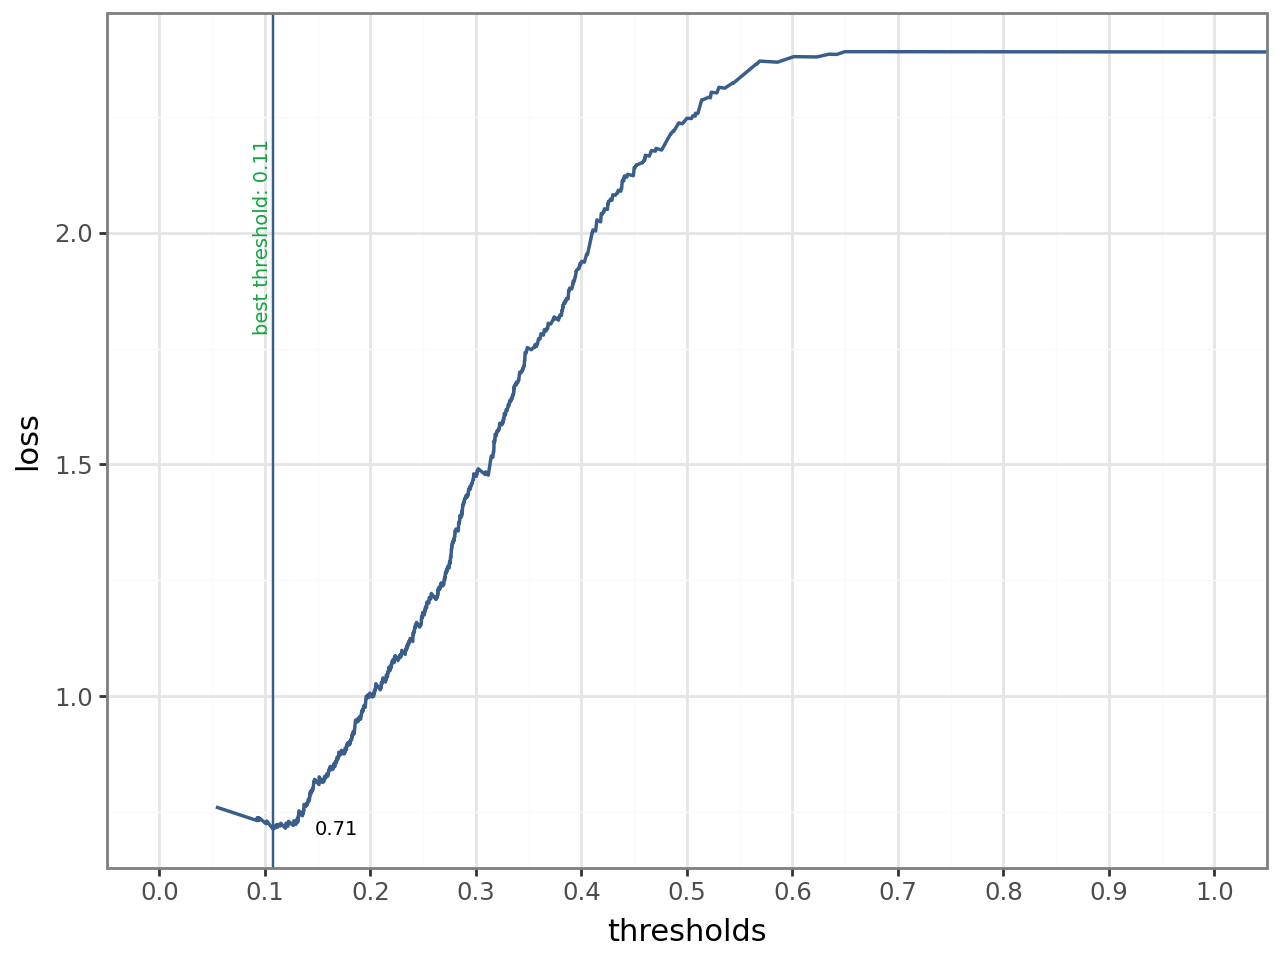

In [356]:
create_loss_plot(all_coords_rf, fold5_threshold_rf, fold5_expected_loss_rf)

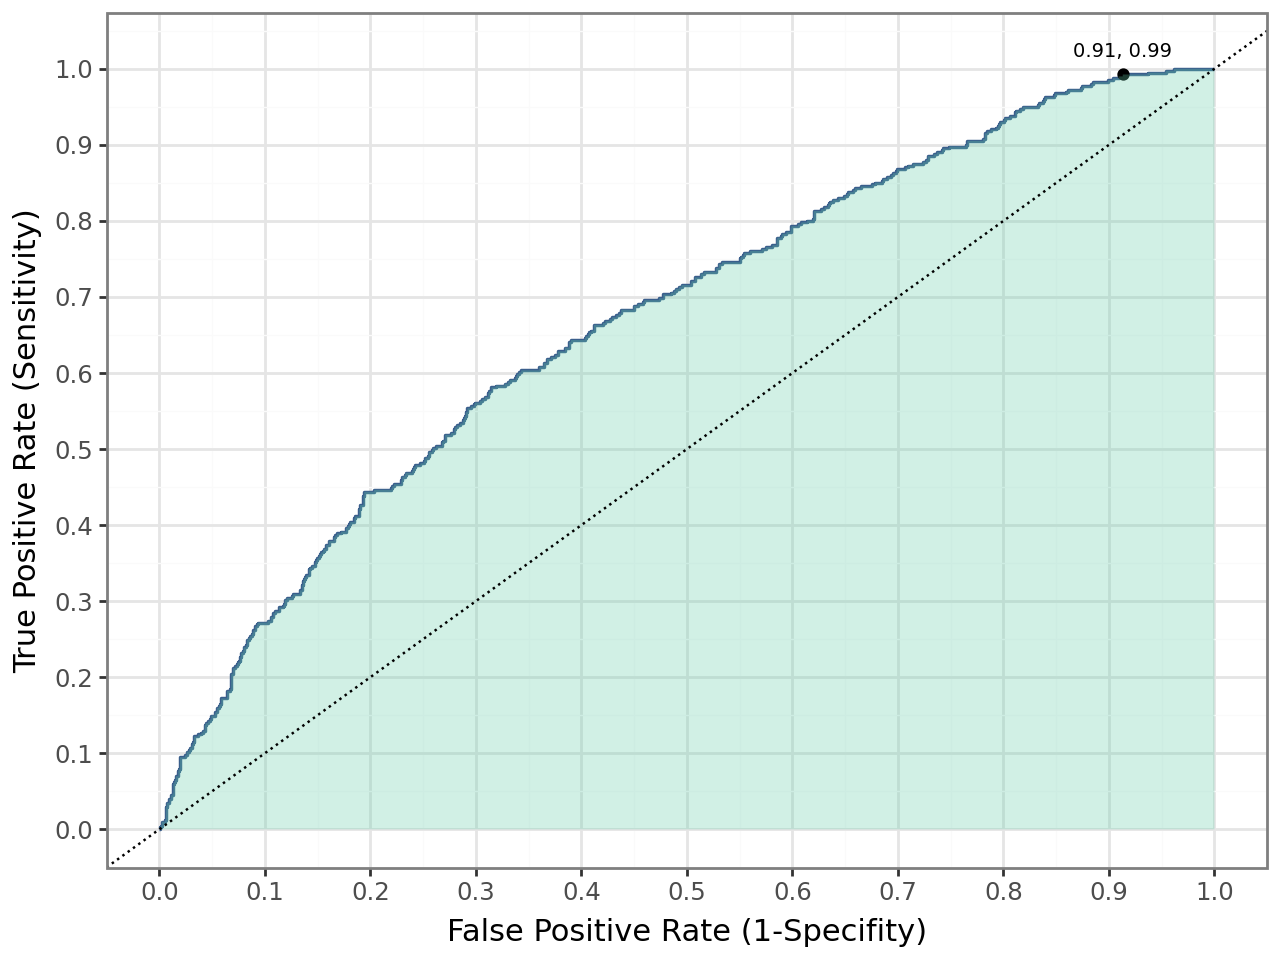

In [358]:
create_roc_plot_with_optimal(all_coords_rf, fold5_threshold_rf)

### Testing our best model - Random Forest, on holout set

Take model to holdout and estimate RMSE, AUC and expected loss

*RMSE on Holout Set*

In [362]:
prob_forest_fit_best = prob_forest_fit.best_estimator_
rf_predicted_probabilities_holdout = prob_forest_fit_best.predict_proba(rfvars_holdout)[
    :, 1
]
rmse_rf = np.sqrt(mean_squared_error(y_holdout, rf_predicted_probabilities_holdout))
round(rmse_rf, 3)

0.416

*ROC AUC on Holdout Set*

In [368]:
auc_rf = roc_auc_score(y_holdout, rf_predicted_probabilities_holdout)
round(auc_rf, 3)

0.667

*Expected Loss on Holdout Set*

In [371]:
holdout_treshold = np.where(
    rf_predicted_probabilities_holdout < best_thresholds_cv["RF"], 0, 1
)
tn, fp, fn, tp = confusion_matrix(y_holdout, holdout_treshold, labels=[0, 1]).ravel()
expected_loss_holdout = (fp * FP + fn * FN) / len(y_holdout)
round(expected_loss_holdout, 3)

0.747

## PART 3: Discussion of Results

*Confusion Matrix on Holdout*

In [379]:
cm_object3 = confusion_matrix(data_holdout["fast_growth"], holdout_treshold, labels=[0, 1])
cm3 = pd.DataFrame(
    cm_object3,
    index=["Actual no fast growth", "Actual fast growth"],
    columns=["Predicted no fast growth", "Predicted fast growth"],
)
cm3

,Predicted no fast growth,Predicted fast growth
Actual no fast growth,83,1498
Actual fast growth,7,511


The model performs well in identifying firms that have fast growth (high TP of 511), but it also has a high number of false positives (1498), indicating it tends to over-predict fast growth. The number of false negatives (7) is quite low, suggesting the model does not miss many fast-growing firms, which is crucial for an investment strategy aiming to capture all potential growth opportunities. However, the large number of false positives may result in investing in firms that aren't actually growing fast, leading to inefficiencies.

With the 10:1 loss function we defined, we're prioritizing not missing any fast-growing firms, which is why the model has a low false negative count (only 7). This is good for ensuring we don’t overlook potential investment opportunities. However, the high number of false positives (1498) suggests the model might be too cautious, predicting fast growth more often to avoid missing any potential winners. If we changed the loss function to a higher ratio (like 20:1), it might reduce false positives, but we could risk missing more fast-growing firms. On the other hand, lowering the penalty for false negatives (say, to 5:1) could help us capture more fast-growing firms, but it might lead to more false positives, meaning we'd be investing in firms that aren’t actually growing as fast.



Accuracy is low at about 28.3%, meaning that the model doesn't perform well overall.
Sensitivity is high at 98.7%, meaning that it does a good job identifying actual fast-growing firms.
Specificity is very low at 5.2%, which means the model is struggling to correctly identify the non-fast-growing firms.
Precision is also low at 25.4%, meaning that most of the firms predicted as fast-growing aren't actually fast-growing.
The F1 score of 0.402 reflects the balance between precision and recall, indicating that there is room for improvement in the model.

In terms of business goals, the model is highly sensitive (which is good for identifying fast-growing firms to invest in), but it misclassifies a lot of non-fast-growing firms as fast-growing, which might lead to too many incorrect investment decisions.

# Task 2: Training & Testing model on 2 different industries

### 0. Defining a single loss function for both industries

In both manufacturing and service industries, missing a high-potential firm (false negative) leads to lost investment opportunities, which is significantly more costly than evaluating a less promising firm (false positive).

In [598]:
FP = 1
FN = 10
cost = FN / FP

## 1 Manufatcuring Industry

In [571]:
# Filter the 'data' dataset where values in 'ind2' column are less than 33 for manufacturing industry
data1 = data[data['ind2'] < 33]


In [573]:
print(data1.shape)


(2735, 118)


Train and test split, use rf best estimator of full dataset to fit model on manufacturings train set first, then predict on manufacturing holdout to do auc, rv, confusion matrix.

Splitting manufacturing dataset into train and test

In [580]:
data1_train, data1_holdout = train_test_split(data1, train_size=0.8, random_state=42)

In [582]:
y1_train, rfvars1_train = patsy.dmatrices("fast_growth~" + "+".join(rfvars), data1_train)
y1_holdout, rfvars1_holdout = patsy.dmatrices("fast_growth~" + "+".join(rfvars), data1_holdout)

Training a new model using on train set of 'manufacturing' dataset's train using best estimators RF model of full dataset

In [585]:
prob_forest_fit_manufacturing = prob_forest_fit_best.fit(rfvars1_train, y1_train)

RMSE on Manufacturing holdout set

In [589]:
rf_predicted_probabilities_manufacturing_holdout = prob_forest_fit_manufacturing.predict_proba(rfvars1_holdout)[
    :, 1
]
rmse_rf = np.sqrt(mean_squared_error(y1_holdout, rf_predicted_probabilities_manufacturing_holdout))
round(rmse_rf, 3)

0.445

AUC on Manufacturing holdout set

In [591]:
auc_rf = roc_auc_score(y1_holdout, rf_predicted_probabilities_manufacturing_holdout)
round(auc_rf, 3)

0.639

Expected loss on Manufacturing holdout set

In [601]:
holdout1_treshold = np.where(
    rf_predicted_probabilities_manufacturing_holdout < best_thresholds_cv["RF"], 0, 1
)
tn, fp, fn, tp = confusion_matrix(y1_holdout, holdout1_treshold, labels=[0, 1]).ravel()
expected_loss_holdout = (fp * FP + fn * FN) / len(y1_holdout)
round(expected_loss_holdout, 3)

0.737

Confusion Table on Manufacturing holdout set

In [603]:
cm_object3_m = confusion_matrix(data1_holdout["fast_growth"], holdout1_treshold, labels=[0, 1])
cm3_m = pd.DataFrame(
    cm_object3_m,
    index=["Actual no fast growth", "Actual fast growth"],
    columns=["Predicted no fast growth", "Predicted fast growth"],
)
cm3_m

,Predicted no fast growth,Predicted fast growth
Actual no fast growth,14,373
Actual fast growth,3,157


## 2. Service Industry

In [606]:
# Filter the 'data' dataset where values in 'ind2' column are equal or greater than 33 for service industry
data2 = data[data['ind2'] >= 33]

In [608]:
print(data2.shape)

(7758, 118)


Splitting service dataset into train and test

In [610]:
data2_train, data2_holdout = train_test_split(data2, train_size=0.8, random_state=42)

In [612]:
y2_train, rfvars2_train = patsy.dmatrices("fast_growth~" + "+".join(rfvars), data2_train)
y2_holdout, rfvars2_holdout = patsy.dmatrices("fast_growth~" + "+".join(rfvars), data2_holdout)

Training a new model using on train set of 'service' dataset's train using best estimators RF model of full dataset

In [614]:
prob_forest_fit_service = prob_forest_fit_best.fit(rfvars2_train, y2_train)

RMSE on Service holdout set

In [616]:
rf_predicted_probabilities_service_holdout = prob_forest_fit_service.predict_proba(rfvars2_holdout)[
    :, 1
]
rmse_rf = np.sqrt(mean_squared_error(y2_holdout, rf_predicted_probabilities_service_holdout))
round(rmse_rf, 3)

0.407

AUC on Service holdout set

In [618]:
auc_rf = roc_auc_score(y2_holdout, rf_predicted_probabilities_service_holdout)
round(auc_rf, 3)

0.654

Expected loss on serive holdout set

In [620]:
holdout2_treshold = np.where(
    rf_predicted_probabilities_service_holdout < best_thresholds_cv["RF"], 0, 1
)
tn, fp, fn, tp = confusion_matrix(y2_holdout, holdout2_treshold, labels=[0, 1]).ravel()
expected_loss_holdout = (fp * FP + fn * FN) / len(y2_holdout)
round(expected_loss_holdout, 3)

0.772

Confusion Table on Service holdout set

In [622]:
cm_object3_s = confusion_matrix(data2_holdout["fast_growth"], holdout2_treshold, labels=[0, 1])
cm3_s = pd.DataFrame(
    cm_object3_s,
    index=["Actual no fast growth", "Actual fast growth"],
    columns=["Predicted no fast growth", "Predicted fast growth"],
)
cm3_s

,Predicted no fast growth,Predicted fast growth
Actual no fast growth,78,1118
Actual fast growth,8,348


### Comparison of Confusion Tables Across Full, Manufacturing, and Service Datasets

The confusion tables for the full, Manufacturing, and Service datasets, when using the best RF estimators from the original dataset, show some interesting patterns. First, while the model shows high sensitivity across all datasets, meaning it’s good at identifying fast-growing firms, accuracy is relatively low due to a large number of false positives. In the Manufacturing subset, accuracy is 0.487, with 157 correct predictions for fast growth, but it also misclassifies 373 non-fast-growing firms as fast-growing. The Service subset has slightly better accuracy at 0.472, with 348 correct predictions for fast growth, but it still misclassifies 1118 non-fast-growing firms as fast-growing. This shows that although the Manufacturing subset performs a bit better in terms of accuracy and precision, both subsets still struggle with high false positives. This is likely due to the 10:1 loss function prioritizing the identification of fast-growing firms over minimizing false positives. Although this makes the model excellent at finding potential high-growth opportunities, it also means that non-growth firms are often misidentified as high-growth ones, which could lead to some risky business decisions. It would be worth exploring ways to adjust the decision threshold or fine-tune the model further to strike a better balance between sensitivity and specificity.